In [791]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.model_selection import LearningCurve

import warnings
warnings.filterwarnings("ignore")

**Датасет:** https://www.kaggle.com/datasets/teertha/personal-loan-modeling

**Бизнес задача:** Руководство банка хочет изучить способы преобразования своих пассивных клиентов в клиентов по потребительским кредитам (при этом сохраняя их в качестве вкладчиков). Кампания, которую банк провел в прошлом году для пассивных клиентов, показала хороший коэффициент конверсии, составивший более 9%. Это побудило отдел розничного маркетинга разработать кампании с более точным целевым маркетингом, чтобы повысить коэффициент успеха при минимальном бюджете. 

**Задача машинного обучения:** Бинарная классификация

# Анализ и предобработка датасета

## Первичный анализ данных

In [747]:
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [748]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [749]:
data.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


В датасете отсутствуют пропущенные значения. Все признаки в численном выражении. Из них:
* ZIP Code, Education, Securities Account, CD Account, Online, CreditCard  - категориальные

Обратим внимание, что в признаке Experience (Опыт работы) минимальное значение отрицательное.

Очевидно, что признак ID не несёт смысловой значимости в поставленной задаче. Уберём его.

In [750]:
y = data[['Personal Loan']]
X = data.drop(columns=['ID', 'Personal Loan'])

In [751]:
cat_cols = ['ZIP Code', 'Education', 'Securities Account', 
            'CD Account', 'Online', 'CreditCard']

X[cat_cols] = X[cat_cols].astype('category')

In [752]:
X.select_dtypes('category').describe()

,ZIP Code,Education,Securities Account,CD Account,Online,CreditCard
count,5000,5000,5000,5000,5000,5000
unique,467,3,2,2,2,2
top,94720,1,0,0,1,0
freq,169,2096,4478,4698,2984,3530


ZIP Code представлен довольно большим числом категорий и не несёт большой смысловой значимости для поставленной задачи. Исключим его из набора признаков.

In [753]:
X = X.drop(columns=['ZIP Code'])

## EDA

### Дисбаланс классов

Проанализируем распределение целевой переменной.

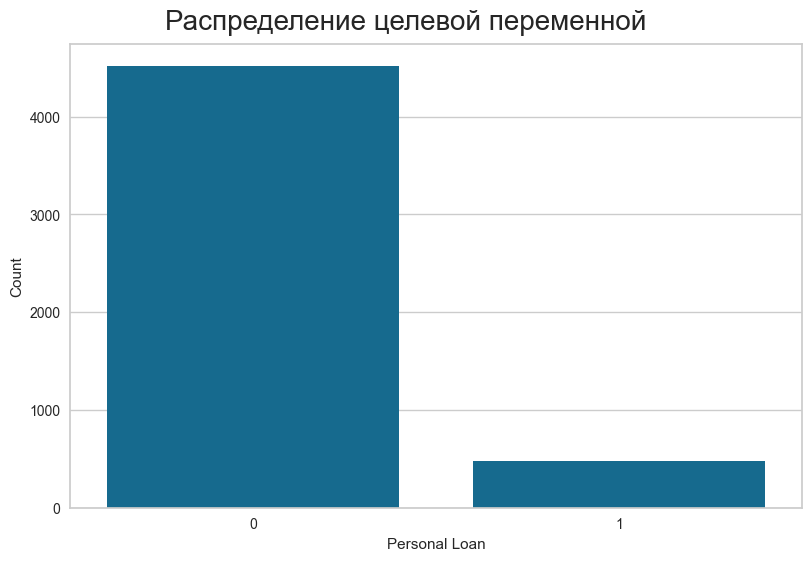

In [754]:
fig, ax = plt.subplots(layout="constrained")

fig.suptitle('Распределение целевой переменной', size=20)

sns.countplot(data=y, x='Personal Loan', linewidth=0, ax=ax)
ax.set_xlabel('Personal Loan')
ax.set_ylabel('Count')

plt.show()

В датасете есть заметный дисбаланс классов. Попробуем решить его с помощью Over-Sampling. Для этого воспользуемся алгоритмом SMOTE, основанным на knn. Для каждого объекта класса меньшинства он определет k ближайших соседей, выбирает один из них и генерирует новый объект класса меньшинства.

In [755]:
cat_cols = ['Education', 'Securities Account', 
            'CD Account', 'Online', 'CreditCard']

smote = SMOTENC(sampling_strategy=0.3, categorical_features=cat_cols) 
X_new, y_new = smote.fit_resample(X, y)

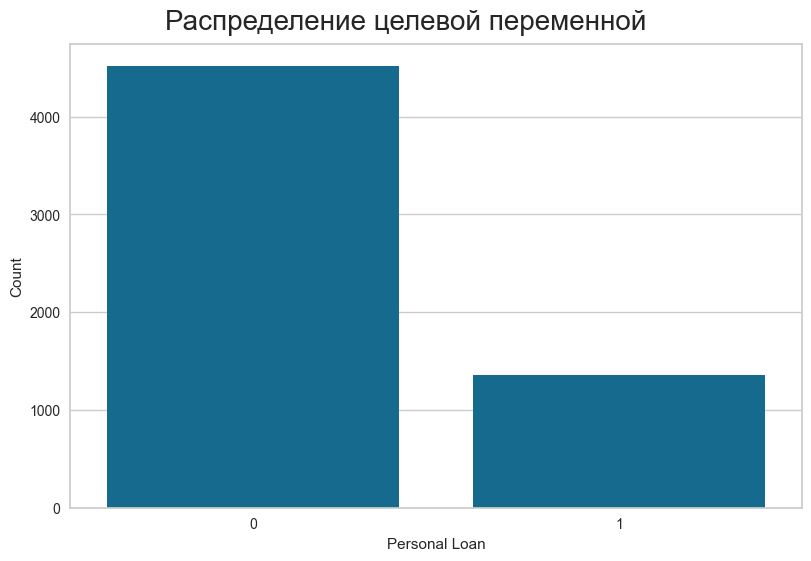

In [756]:
fig, ax = plt.subplots(layout="constrained")

fig.suptitle('Распределение целевой переменной', size=20)

sns.countplot(data=y_new, x='Personal Loan', linewidth=0, ax=ax)
ax.set_xlabel('Personal Loan')
ax.set_ylabel('Count')

plt.show()

Слишком большое число синтетических данных может привести к переобучению, а удаление объектов - к ухудшению обобщающей способности. В обработанных данных дисбаланс классов смягчился. Однако в данном случае лучшим решением стало бы найти больше данных. Это не всегда возможно, особенно когда решаются настоящие бизнес задачи. При разделении выборки будет учтён дисбаланс классов. Перейдём к анализу объясняющих признаков.

### Анализ признаков

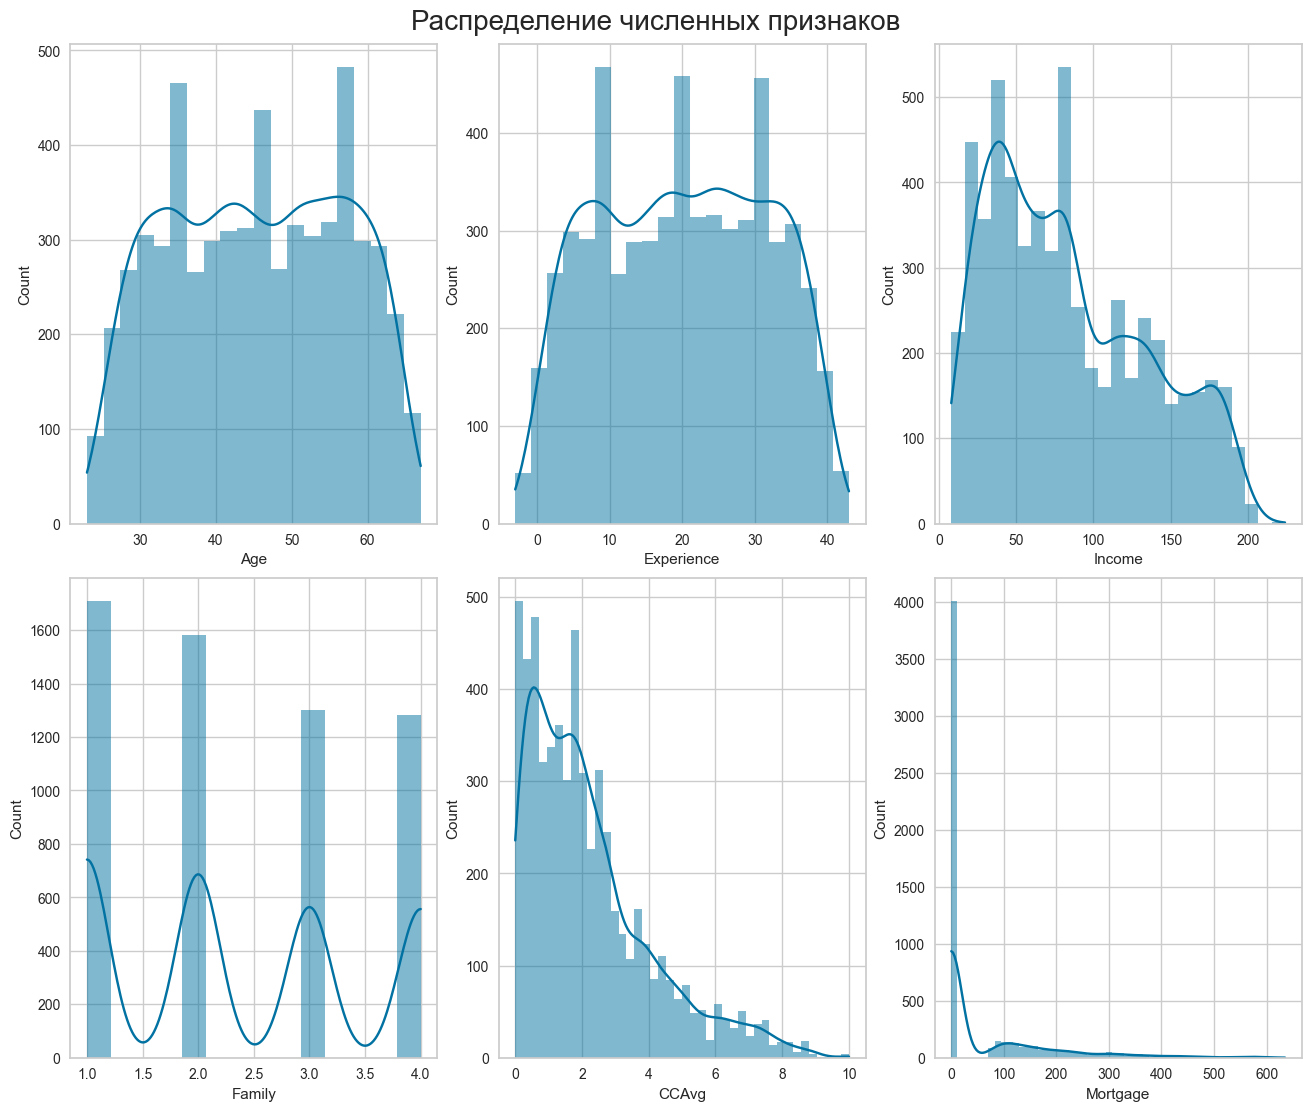

In [757]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13, 11), layout="constrained")

fig.suptitle('Распределение численных признаков', size=20)

for ind, col in enumerate(X.select_dtypes(exclude='category').columns):
    sns.histplot(data=X_new, x=col, linewidth=0, ax=axes[ind // 3, ind % 3], kde=True)
    axes[ind // 3, ind % 3].set_xlabel(col)
    axes[ind // 3, ind % 3].set_ylabel('Count')

plt.show()

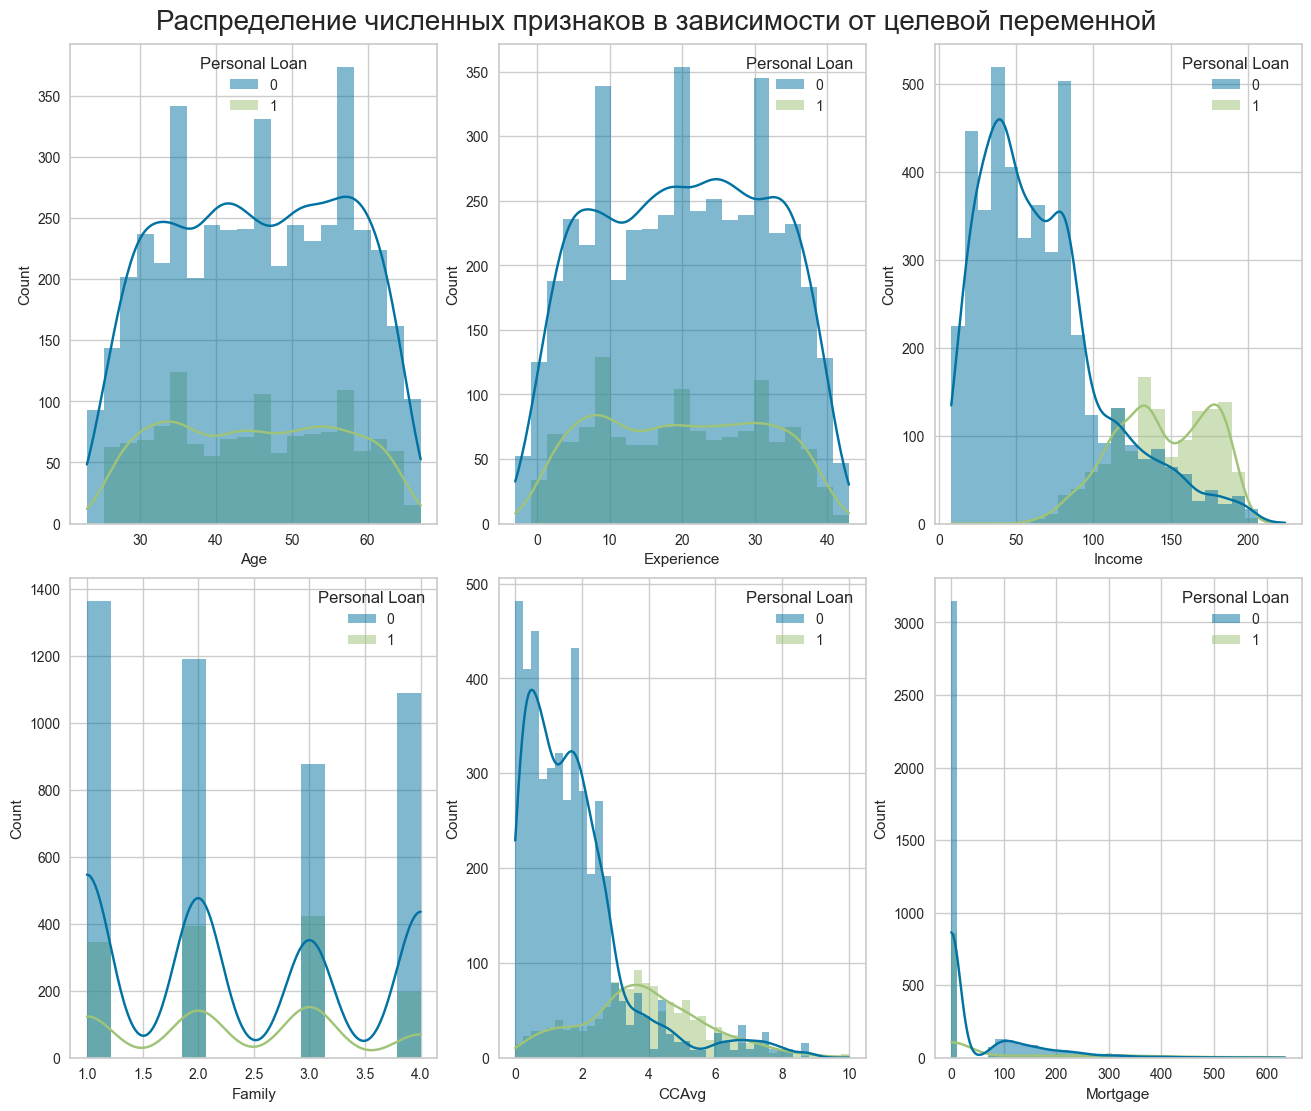

In [758]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13, 11), layout="constrained")

fig.suptitle('Распределение численных признаков в зависимости от целевой переменной', size=20)

data_ = X_new.copy()
data_['Personal Loan'] = y_new


for ind, col in enumerate(X.select_dtypes(exclude='category').columns):
    sns.histplot(data=data_, x=col, linewidth=0, hue='Personal Loan', ax=axes[ind // 3, ind % 3], kde=True)
    axes[ind // 3, ind % 3].set_xlabel(col)
    axes[ind // 3, ind % 3].set_ylabel('Count')

plt.show()

Можно сделать следующие выводы:

* Необходимо избавиться от выброса в виде отрицательных значений признака Experience.
* Подавляющее большинство значений признака Mortgage - 0. Разумнее заменить его на бинарный признак со значениями "есть ипотека" и "нет ипотеки".
* Заметно, что признаки Income и CCAvg сильно влияют на распределение целевой переменной. Сгруппируем численные значения этих признаков в категории.

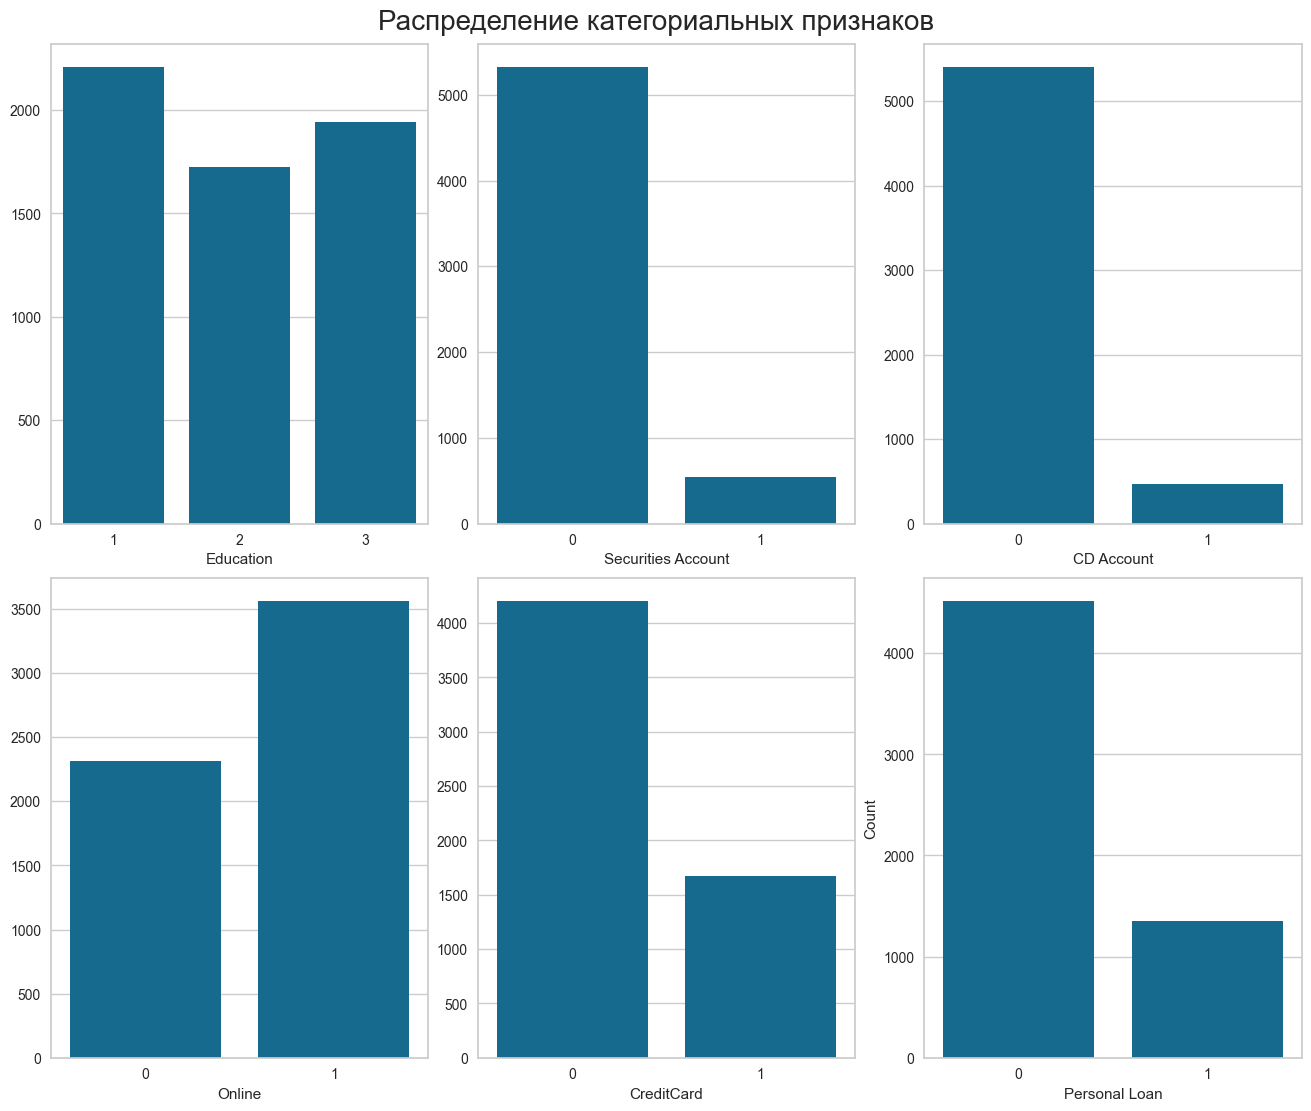

In [759]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13, 11), layout="constrained")

fig.suptitle('Распределение категориальных признаков', size=20)

for ind, col in enumerate(X.select_dtypes(include='category').columns):
    sns.countplot(data=X_new, x=col, linewidth=0, ax=axes[ind // 3, ind % 3])
    axes[ind // 3, ind % 3].set_xlabel(col)
    axes[ind // 3, ind % 3].set_ylabel('')

sns.countplot(data=y_new, x='Personal Loan', linewidth=0, ax=axes[1, 2])
axes[1, 2].set_xlabel('Personal Loan')
axes[1, 2].set_ylabel('Count')

plt.show()

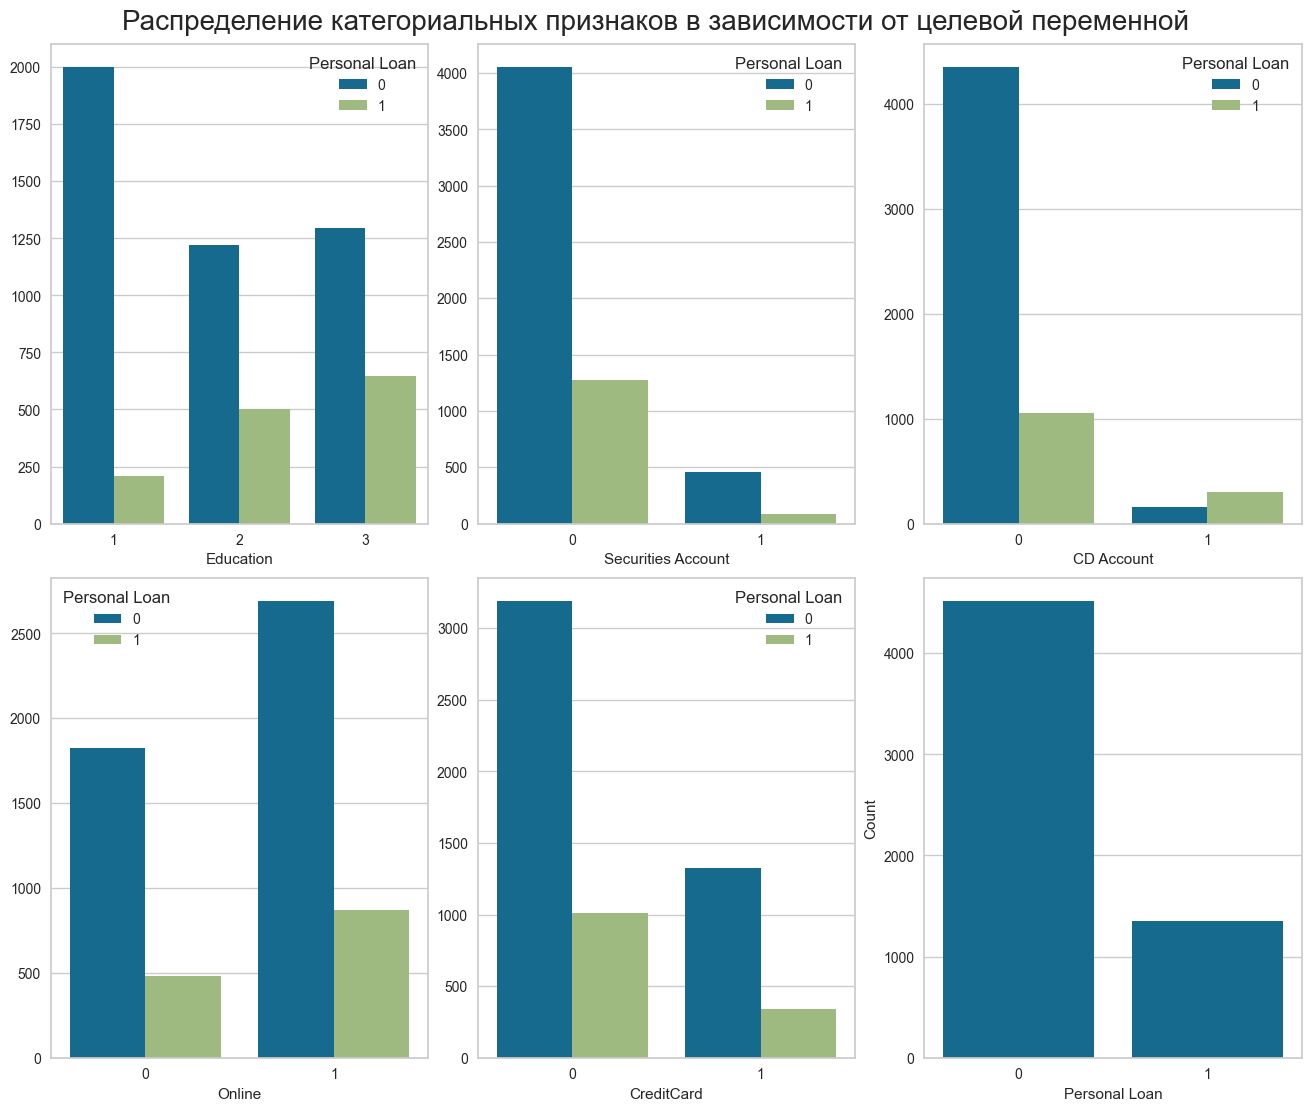

In [760]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13, 11), layout="constrained")

fig.suptitle('Распределение категориальных признаков в зависимости от целевой переменной', size=20)

data_ = X_new.copy()
data_['Personal Loan'] = y_new

for ind, col in enumerate(X.select_dtypes(include='category').columns):
    sns.countplot(data=data_, x=col, linewidth=0, hue='Personal Loan', ax=axes[ind // 3, ind % 3])
    axes[ind // 3, ind % 3].set_xlabel(col)
    axes[ind // 3, ind % 3].set_ylabel('')

sns.countplot(data=y_new, x='Personal Loan', linewidth=0, ax=axes[1, 2])
axes[1, 2].set_xlabel('Personal Loan')
axes[1, 2].set_ylabel('Count')

plt.show()

Очевидно, что больше всего на целевую переменную влияет наличие образования у клиента.

## Предобработка данных

Переведём признаки Income и CCAvg в категориальные.

In [761]:
bin_ranges = [0, 50, 100, 150, X_new['Income'].max()]
bin_names = ['low', 'lower_middle', 'upper_middle', 'high']

X_new['Income_labels'] = pd.cut(np.array(X_new['Income']),
                                bins=bin_ranges, labels=bin_names, 
                                include_lowest=True)
X_new.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Income_labels
0,25,1,49,4,1.6,1,0,1,0,0,0,low
1,45,19,34,3,1.5,1,0,1,0,0,0,low
2,39,15,11,1,1.0,1,0,0,0,0,0,low
3,35,9,100,1,2.7,2,0,0,0,0,0,lower_middle
4,35,8,45,4,1.0,2,0,0,0,0,1,low


In [762]:
bin_ranges = [X_new['CCAvg'].min(), 3, 6, X_new['CCAvg'].max()]
bin_names = ['low', 'moderate', 'high']

X_new['CCAVG_labels'] = pd.cut(np.array(X_new['CCAvg']),
                               bins=bin_ranges, labels=bin_names,
                               include_lowest=True)

X_new.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Income_labels,CCAVG_labels
0,25,1,49,4,1.6,1,0,1,0,0,0,low,low
1,45,19,34,3,1.5,1,0,1,0,0,0,low,low
2,39,15,11,1,1.0,1,0,0,0,0,0,low,low
3,35,9,100,1,2.7,2,0,0,0,0,0,lower_middle,low
4,35,8,45,4,1.0,2,0,0,0,0,1,low,low


Бинаризуем признак Mortgage.

In [763]:
X_new['hasMortgage'] = np.where(X_new['Mortgage'] == 0, 0, 1)

X_new.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Income_labels,CCAVG_labels,hasMortgage
0,25,1,49,4,1.6,1,0,1,0,0,0,low,low,0
1,45,19,34,3,1.5,1,0,1,0,0,0,low,low,0
2,39,15,11,1,1.0,1,0,0,0,0,0,low,low,0
3,35,9,100,1,2.7,2,0,0,0,0,0,lower_middle,low,0
4,35,8,45,4,1.0,2,0,0,0,0,1,low,low,0


In [764]:
X_new[['hasMortgage', 'CCAVG_labels', 'Income_labels']] = X_new[['hasMortgage', 'CCAVG_labels', 'Income_labels']].astype('category')

Заменим отрицательные значения признака Experience на 0.

In [765]:
X_new[X_new['Experience'] < 0]['Experience'] = 0

## Подготовка признаков

Закодируем категориальные признаки OneHotEncoder.

In [766]:
col_drop = ['Income', 'CCAvg', 'Mortgage']

X_d = X_new.drop(columns=col_drop)

In [767]:
X_d = pd.get_dummies(X_d, drop_first=True)
X_d.head()

,Age,Experience,Family,Education_2,Education_3,Securities Account_1,CD Account_1,Online_1,CreditCard_1,Income_labels_lower_middle,Income_labels_upper_middle,Income_labels_high,CCAVG_labels_moderate,CCAVG_labels_high,hasMortgage_1
0,25,1,4,False,False,True,False,False,False,False,False,False,False,False,False
1,45,19,3,False,False,True,False,False,False,False,False,False,False,False,False
2,39,15,1,False,False,False,False,False,False,False,False,False,False,False,False
3,35,9,1,True,False,False,False,False,False,True,False,False,False,False,False
4,35,8,4,True,False,False,False,False,True,False,False,False,False,False,False


## Разделение выборки

In [768]:
X_train, X_test, y_train, y_test = train_test_split(X_d, y_new, test_size=0.3, stratify=y_new, random_state=42)

# Выбор метрик

Рассмотрим следующие метрики:
* Accuracy - стандартная мера качества моделей классификации. Может показать, насколько точны предсказания модели.
* Precision - доля правильно предсказанных положительных классов ко всем предсказаниям положительного класса. Так как на воздействие на клиентов необходимо потратить ресурсы, нам нужно убедиться, что модель будет как можно меньше давать FP предсказания.
* ROC-AUC - метрика, показывающая соотношение FPR и TPR. По сути метрика является отражением того, насколкьо хорошо модель отличает положительные классы и насколько плохо справляется с отрицательными.

# Выбор и обучение моделей

Рассмотрим следующие модели классификации:

* Логистическая регрессия
* Метод опорных векторов
* Дерево решений
* K ближайших соседей

In [769]:
logreg = LogisticRegression(max_iter=3000)

cv_res = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')

print(f'CV RESULTS: {list(map(lambda a: round(a, 3), cv_res))}')
print(f'CV MEAN: {np.round(np.mean(cv_res), 3)}')
print(f'CV STD: {np.round(np.std(cv_res), 3)}')

CV RESULTS: [0.878, 0.893, 0.923, 0.904, 0.883]
CV MEAN: 0.896
CV STD: 0.016


In [770]:
svc = SVC(kernel='linear')

cv_res = cross_val_score(svc, X_train, y_train, cv=5, scoring='precision')

print(f'CV RESULTS: {list(map(lambda a: round(a, 3), cv_res))}')
print(f'CV MEAN: {np.round(np.mean(cv_res), 3)}')
print(f'CV STD: {np.round(np.std(cv_res), 3)}')

CV RESULTS: [0.914, 0.896, 0.91, 0.906, 0.902]
CV MEAN: 0.906
CV STD: 0.006


In [771]:
tree = DecisionTreeClassifier()

cv_res = cross_val_score(tree, X_train, y_train, cv=5, scoring='precision')

print(f'CV RESULTS: {list(map(lambda a: round(a, 3), cv_res))}')
print(f'CV MEAN: {np.round(np.mean(cv_res), 3)}')
print(f'CV STD: {np.round(np.std(cv_res), 3)}')

CV RESULTS: [0.848, 0.929, 0.941, 0.937, 0.897]
CV MEAN: 0.91
CV STD: 0.035


In [772]:
knn = KNeighborsClassifier()

cv_res = cross_val_score(knn, X_train, y_train, cv=5, scoring='precision')

print(f'CV RESULTS: {list(map(lambda a: round(a, 3), cv_res))}')
print(f'CV MEAN: {np.round(np.mean(cv_res), 3)}')
print(f'CV STD: {np.round(np.std(cv_res), 3)}')

CV RESULTS: [0.786, 0.929, 0.941, 0.833, 0.894]
CV MEAN: 0.877
CV STD: 0.059


Классификатор, основанный на деревьях решений показал лучшее значение метрики Precision. Проведём его подробную диагностику.

# Диагностика модели

In [773]:
model = DecisionTreeClassifier().fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [774]:
print("Precision")
print(f"Training score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test score: {precision_score(y_test, y_pred_test):.4f}")

Precision
Training score: 1.0000
Test score: 0.9039


In [776]:
print("ROC-AUC score")
print(f"Training score: {roc_auc_score(y_train, y_pred_train):.4f}")
print(f"Test score: {roc_auc_score(y_test, y_pred_test):.4f}")

ROC-AUC score
Training score: 0.9989
Test score: 0.9365


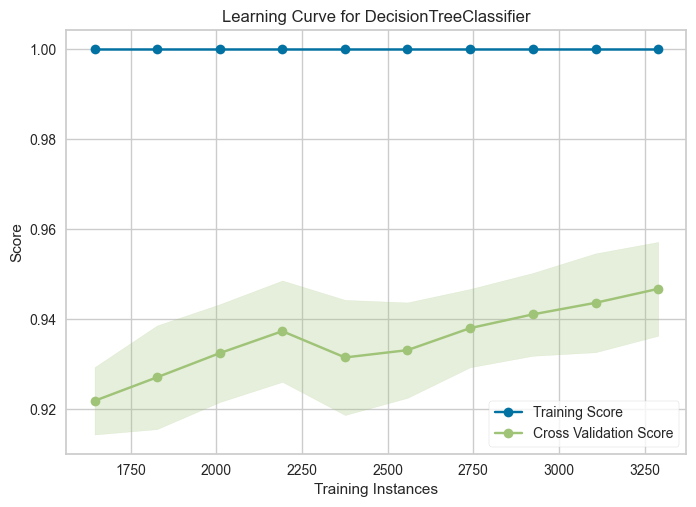

In [778]:
visualizer = LearningCurve(
    DecisionTreeClassifier(), train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='roc_auc'
).fit(X_train, y_train).show() 

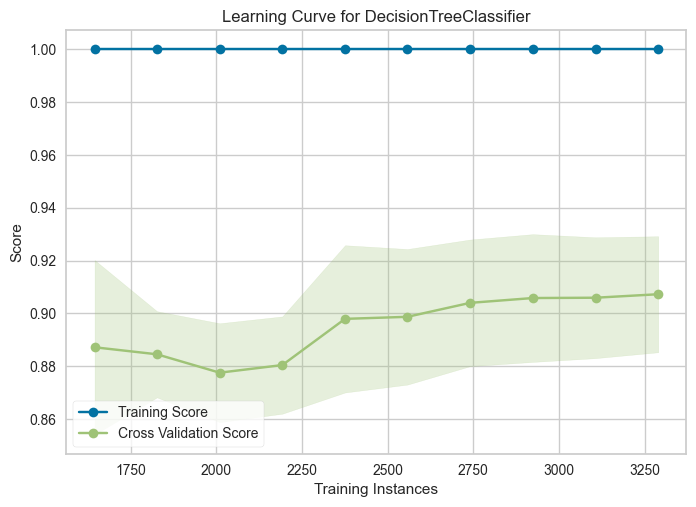

In [779]:
visualizer = LearningCurve(
    DecisionTreeClassifier(), train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='precision'
).fit(X_train, y_train).show() 

Модель заметно переобучается. Попробуем подобрать гиперпараметры модели, чтобы решить эту проблему.

# Подбор гиперпараметров

Подберём параметр глубины дерева с помощью GridSearch.

In [780]:
param_grid = {'max_depth': np.arange(1, 20, 1)}

grid_model = GridSearchCV(estimator=DecisionTreeClassifier(),
                          param_grid=param_grid,
                          scoring='precision',
                          cv=5)

In [781]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             scoring='precision')

In [782]:
best_depth = grid_model.best_params_['max_depth']
best_depth

6

Повторим диагностику оптимизированной модели.

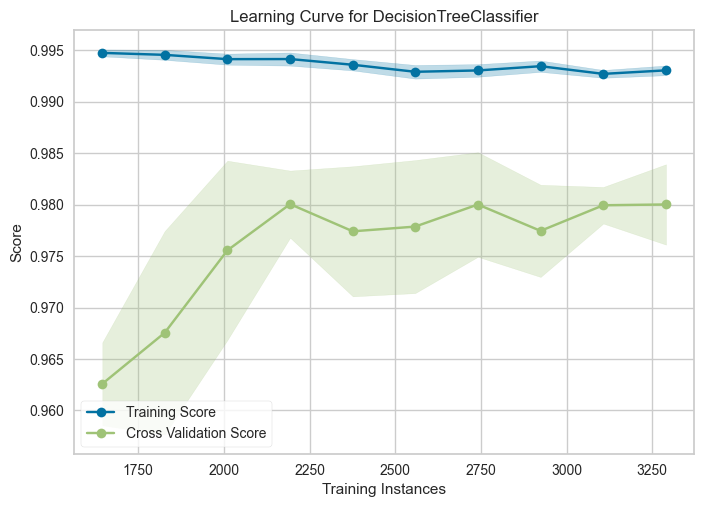

In [784]:
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=best_depth), train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='roc_auc'
).fit(X_train, y_train).show() 

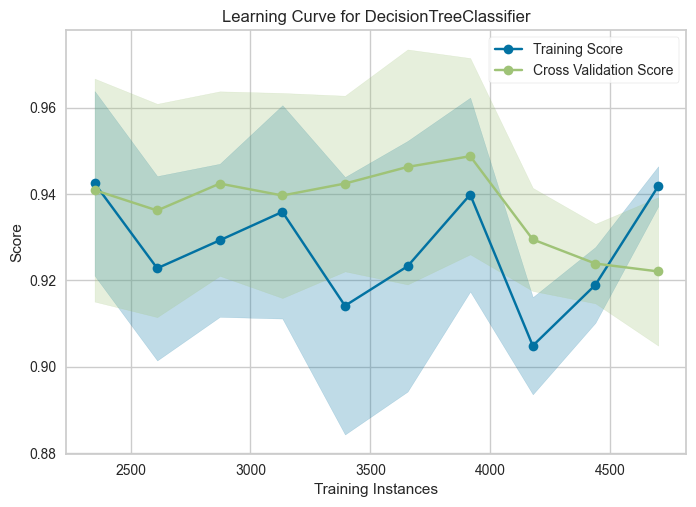

In [785]:
visualizer = LearningCurve(
    DecisionTreeClassifier(max_depth=best_depth), train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='precision'
).fit(X_d, y_new).show() 

Переобучение модели заметно снизилось. Модель показывает хорошие результаты целевой метрики Precision, а значит, в случае обнаружения положительного класса она делает точное предсказание.

**Итоговые метрики:**

In [786]:
tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

In [787]:
print("Precision")
print(f"Training score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test score: {precision_score(y_test, y_pred_test):.4f}")

Precision
Training score: 0.9401
Test score: 0.8969


In [789]:
print("ROC-AUC score")
print(f"Training score: {roc_auc_score(y_train, y_pred_train):.4f}")
print(f"Test score: {roc_auc_score(y_test, y_pred_test):.4f}")

ROC-AUC score
Training score: 0.9543
Test score: 0.9436


# Ансамблевые модели

Попробуем построить ансамблевую модель.

In [821]:
model = RandomForestClassifier()

cv_res = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

print(f'CV RESULTS: {list(map(lambda a: round(a, 3), cv_res))}')
print(f'CV MEAN: {np.round(np.mean(cv_res), 3)}')
print(f'CV STD: {np.round(np.std(cv_res), 3)}')

CV RESULTS: [0.898, 0.96, 0.938, 0.936, 0.941]
CV MEAN: 0.935
CV STD: 0.02


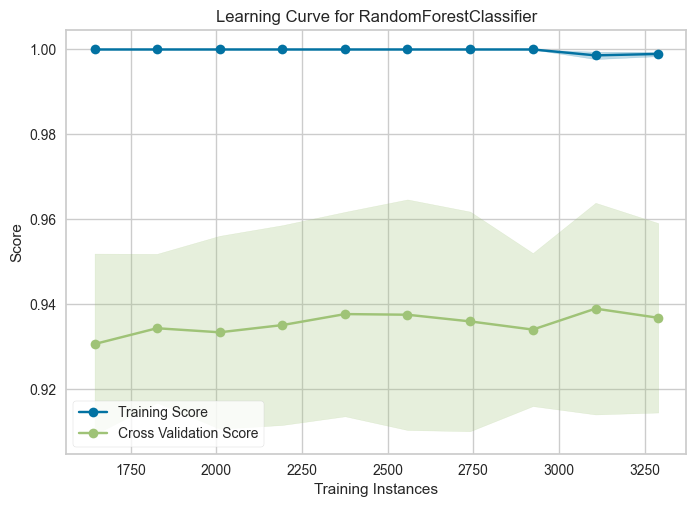

In [822]:
visualizer = LearningCurve(
    RandomForestClassifier(), train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='precision'
).fit(X_train, y_train).show() 

In [830]:
param_grid = {'max_depth': np.arange(1, 10), 'n_estimators': np.arange(100, 200, 10)}

grid_model = GridSearchCV(estimator=RandomForestClassifier(),
                          param_grid=param_grid,
                          scoring=['precision', 'roc_auc'],
                          cv=5, 
                          refit='precision')

In [831]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])},
             refit='precision', scoring=['precision', 'roc_auc'])

In [832]:
grid_model.best_params_

{'max_depth': 2, 'n_estimators': 140}

In [841]:
tree = RandomForestClassifier(max_depth=2, n_estimators=140).fit(X_train, y_train)

y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

In [842]:
print("Precision")
print(f"Training score: {precision_score(y_train, y_pred_train):.4f}")
print(f"Test score: {precision_score(y_test, y_pred_test):.4f}")

Precision
Training score: 0.9846
Test score: 0.9885


In [844]:
print("ROC-AUC score")
print(f"Training score: {roc_auc_score(y_train, y_pred_train):.4f}")
print(f"Test score: {roc_auc_score(y_test, y_pred_test):.4f}")

ROC-AUC score
Training score: 0.6007
Test score: 0.6053


Ансамблевая модель справилась хуже, чем настроенное дерево решений. 

# Выводы

По итогам данной работы было выявлено, что лучше всего с поставленной задачей справилось дерево решений. Были проделаны основыне этапы работы с данными, обучения и диагностики моделей.